In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import math

import pandas as pd
import numpy as np
import pennylane as qml
from pennylane import numpy as qnp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42) 
qnp.random.seed(42)

In [3]:
def plot_training_results(
    hist_no,
    hist_yes,
    cm_no,
    cm_yes,
    village_name,
    figsize_1=(12, 4),
    figsize_2=(10, 4)
):

    fig, ax = plt.subplots(1, 2, figsize=figsize_1)

    ax[0].plot(hist_no['train_acc'], label='Train (No Re-up)', linestyle='--')
    ax[0].plot(hist_no['test_acc'], label='Test (No Re-up)')
    ax[0].plot(hist_yes['train_acc'], label='Train (With Re-up)', linestyle='--')
    ax[0].plot(hist_yes['test_acc'], label='Test (With Re-up)')
    ax[0].set_title(f'Accuracy: {village_name}')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    ax[1].plot(hist_no['loss'], label='Loss (No Re-up)')
    ax[1].plot(hist_yes['loss'], label='Loss (With Re-up)')
    ax[1].set_title(f'Loss: {village_name}')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=figsize_2)

    plt.subplot(1, 2, 1)
    sns.heatmap(cm_no, annot=True, fmt='d', cmap='Blues')
    plt.title("CM: No Re-upload")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_yes, annot=True, fmt='d', cmap='Greens')
    plt.title("CM: With Re-upload")

    plt.tight_layout()
    plt.show()


First we load the datasets:

In [4]:
gluehwein = 'gluehweindorf'
krampus = 'krampuskogel'
lebkuchen = 'lebkuchenstadt'

villages = [gluehwein, krampus, lebkuchen]
datasets = {}

for village in villages:
        datasets[village] = pd.read_csv(f'{village}.csv')

There are no null values in the dataset and 500 entries

In [5]:
datasets[gluehwein].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carol_singing    500 non-null    float64
 1   snowball_energy  500 non-null    float64
 2   label            500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [6]:
datasets[krampus].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carol_singing    500 non-null    float64
 1   snowball_energy  500 non-null    float64
 2   label            500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [7]:
datasets[lebkuchen].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carol_singing    500 non-null    float64
 1   snowball_energy  500 non-null    float64
 2   label            500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


Min-Max values

In [8]:
for name in (gluehwein, krampus, lebkuchen):
    print(f'{name}-carol_singing: min: {datasets[name]['carol_singing'].min()}, max: {datasets[name]['carol_singing'].max()}')
    print(f'{name}-snowball_energy: min: {datasets[name]['snowball_energy'].min()}, max: {datasets[name]['snowball_energy'].max()}')
    print()

gluehweindorf-carol_singing: min: -2.9804047381428838, max: 2.9371221242497527
gluehweindorf-snowball_energy: min: -2.9723258785728337, max: 3.141592653589793

krampuskogel-carol_singing: min: -3.141592653589793, max: 3.117552213512825
krampuskogel-snowball_energy: min: -2.8957902158960995, max: 2.8898416183940667

lebkuchenstadt-carol_singing: min: -1.620977694446723, max: 3.141592653589793
lebkuchenstadt-snowball_energy: min: -0.6755685974503365, max: 1.4214525718679278



In [9]:
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))

for name in (gluehwein, krampus, lebkuchen):
    for col in ('carol_singing', 'snowball_energy'):
        data = datasets[name][col].values.reshape(-1, 1)
        
        # Fit and transform the data
        datasets[name][col] = scaler.fit_transform(data).flatten()

In [10]:
for name in (gluehwein, krampus, lebkuchen):
    print(f'{name}-carol_singing: min: {datasets[name]['carol_singing'].min()}, max: {datasets[name]['carol_singing'].max()}')
    print(f'{name}-snowball_energy: min: {datasets[name]['snowball_energy'].min()}, max: {datasets[name]['snowball_energy'].max()}')
    print()

gluehweindorf-carol_singing: min: -3.141592653589793, max: 3.141592653589794
gluehweindorf-snowball_energy: min: -3.141592653589793, max: 3.141592653589793

krampuskogel-carol_singing: min: -3.141592653589793, max: 3.141592653589793
krampuskogel-snowball_energy: min: -3.141592653589793, max: 3.1415926535897936

lebkuchenstadt-carol_singing: min: -3.141592653589793, max: 3.1415926535897927
lebkuchenstadt-snowball_energy: min: -3.141592653589793, max: 3.1415926535897936



Label values

In [11]:
for name in (gluehwein, krampus, lebkuchen):
    print(f'{name}-labels:  {datasets[gluehwein]['label'].unique()}')


gluehweindorf-labels:  [1 0]
krampuskogel-labels:  [1 0]
lebkuchenstadt-labels:  [1 0]


In [12]:
X_train = {}
y_train = {}

for name in (gluehwein, krampus, lebkuchen):
    X_train[name] = datasets[name][['carol_singing', 'snowball_energy']].values
    y_train[name] = datasets[name]['label'].values

# Encoding

## Amplitude encoding

In [13]:
def amplitude_encoding(inputs, wires):
    qml.AmplitudeEmbedding(
        features=inputs,
        wires=wires,
        normalize=True,
        pad_with=0.0
    )


## Angle encoding

In [14]:
def angle_encoding(inputs, wires):
    qml.AngleEmbedding(
        features=inputs, 
        wires=wires, 
        rotation='Y')

## Density matrix encoding


In [15]:
def density_matrix_encoding(inputs, wires):    
    x0, x1 = inputs
    rho = np.outer(inputs, inputs) / np.inner(inputs, inputs)

    qml.QubitDensityMatrix(rho, wires=wires)

# Entanglement

## Linear Entanglement

In [16]:
def linear_entanglement(wires):
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])

## Circular Entanglement

In [17]:
def circular_entanglement(wires):
    linear_entanglement(wires)
    qml.CNOT(wires=[wires[-1], wires[0]])


## Full Entanglement

In [18]:
def full_entanglement(wires):
    for i in range(len(wires)):
        for j in range(i + 1, len(wires)):
            qml.CNOT(wires=[wires[i], wires[j]])


# QML Circuit

In [19]:
def angle_encoding_reuploading(inputs, wires):
    """Encodes features using RX and RY for each qubit."""
    for i in wires:
        qml.RX(inputs[0], wires=i)
        qml.RY(inputs[1], wires=i)

def make_qml_circuit(dev):
    @qml.qnode(dev)
    def qml_circuit(weights, inputs, encoding_fn, entanglement_fn, reuploading_count):
        num_qubits = len(dev.wires)
        
        for j in range(reuploading_count):
            # 1. Encoding (Re-uploading)
            encoding_fn(inputs, wires=range(num_qubits))
            
            # 2. Entanglement
            entanglement_fn(wires=range(num_qubits))
            
            # 3. Trainable Layer (Full Rotations)
            for i in range(num_qubits):
                qml.Rot(weights[j, i, 0], weights[j, i, 1], weights[j, i, 2], wires=i)

        return qml.expval(qml.PauliZ(0))
    
    return qml_circuit

# Cost

In [20]:
def cost(weights, params):
    X, Y, circuit, encoding_fn, entang_fn, reupload_cnt = params
    predictions = qnp.array([
        (circuit(weights, x, encoding_fn, entang_fn, reupload_cnt) * 0.5 + 0.5)
        for x in X
    ])
    eps = 1e-7
    return -qnp.mean(Y * qnp.log(predictions + eps) + (1 - Y) * qnp.log(1 - predictions + eps))

In [21]:
def predict_proba(weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count):
    return qnp.array([
        (qml_circuit(weights, x, encoding_fn, entanglement_fn, reuploading_count) + 1) / 2
        for x in X
    ])


def predict(weights, X, circuit, encoding_fn, entang_fn, reupload_cnt):
    return qnp.array([circuit(weights, x, encoding_fn, entang_fn, reupload_cnt) for x in X]) > 0

def accuracy(y_true, y_pred):
    return qnp.mean(y_true == y_pred)


def confusion_matrix(y_true, y_pred):
    tp = qnp.sum((y_true == 1) & (y_pred == 1))
    tn = qnp.sum((y_true == 0) & (y_pred == 0))
    fp = qnp.sum((y_true == 0) & (y_pred == 1))
    fn = qnp.sum((y_true == 1) & (y_pred == 0))

    return qnp.array([[tn, fp],
                      [fn, tp]])


# Evaluation

## Gluehweindorf

Starting Training: gluehweindorf | Re-upload: False
Epoch   1 | Cost: 0.6660 | Accuracy train: 0.652 | Accuracy test: 0.670
Epoch   2 | Cost: 0.6366 | Accuracy train: 0.738 | Accuracy test: 0.700
Epoch   3 | Cost: 0.6088 | Accuracy train: 0.770 | Accuracy test: 0.730
Epoch   4 | Cost: 0.5826 | Accuracy train: 0.792 | Accuracy test: 0.770
Epoch   5 | Cost: 0.5581 | Accuracy train: 0.785 | Accuracy test: 0.790
Epoch   6 | Cost: 0.5357 | Accuracy train: 0.780 | Accuracy test: 0.800
Epoch   7 | Cost: 0.5158 | Accuracy train: 0.782 | Accuracy test: 0.800
Epoch   8 | Cost: 0.4986 | Accuracy train: 0.785 | Accuracy test: 0.810
Epoch   9 | Cost: 0.4844 | Accuracy train: 0.790 | Accuracy test: 0.810
Epoch  10 | Cost: 0.4730 | Accuracy train: 0.800 | Accuracy test: 0.820
Epoch  11 | Cost: 0.4645 | Accuracy train: 0.807 | Accuracy test: 0.840
Epoch  12 | Cost: 0.4586 | Accuracy train: 0.818 | Accuracy test: 0.850
Epoch  13 | Cost: 0.4551 | Accuracy train: 0.818 | Accuracy test: 0.850
Epoch  14 | 

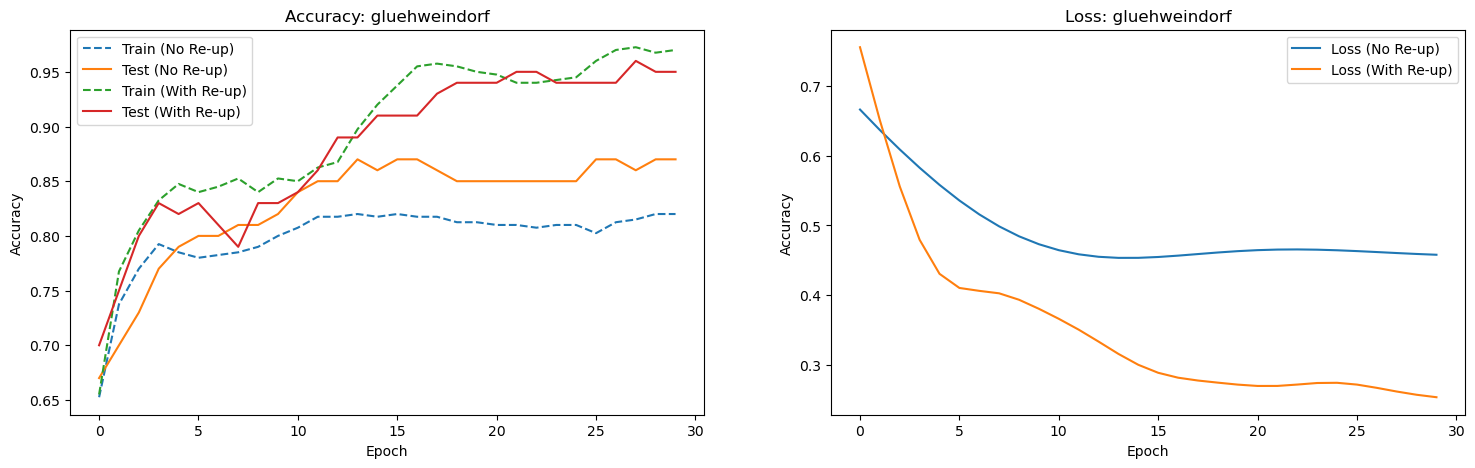

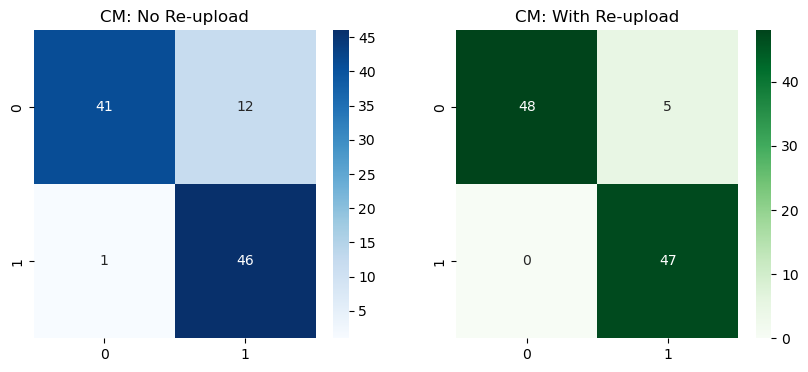

In [22]:
village_name = gluehwein 
num_qubits = 2
learning_rate = 0.1

def train_and_evaluate(use_reupload, epochs):
    count = 3 if use_reupload else 1
    
    dev = qml.device("default.qubit", wires=num_qubits)
    circuit = make_qml_circuit(dev)
    
    # Data Split
    X_v = qnp.array(X_train[village_name], requires_grad=False)
    Y_v = qnp.array(y_train[village_name], requires_grad=False)
    X_tr, X_te, Y_tr, Y_te = train_test_split(X_v, Y_v, test_size=0.2, random_state=12317240)

    weights = qnp.array(
        np.random.uniform(0, 2 * np.pi, size=(count, num_qubits, 3)),
        requires_grad=True
    )
    
    opt = qml.AdamOptimizer(stepsize=learning_rate)
    
    history = {'loss': [], 'train_acc': [], 'test_acc': []}
    
    print(f"Starting Training: {village_name} | Re-upload: {use_reupload}")
    
    for epoch in range(epochs):
        params = [X_tr, Y_tr, circuit, angle_encoding_reuploading, circular_entanglement, count]
        weights, current_cost = opt.step_and_cost(cost, weights, params=params)
        
        # Predictions for metrics
        pred_tr = predict(weights, X_tr, circuit, angle_encoding_reuploading, circular_entanglement, count)
        pred_te = predict(weights, X_te, circuit, angle_encoding_reuploading, circular_entanglement, count)
        
        train_acc = qnp.mean(pred_tr == Y_tr)
        test_acc = qnp.mean(pred_te == Y_te)
        
        history['loss'].append(current_cost)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        
        print(f"Epoch {epoch+1:3d} | Cost: {current_cost:.4f} | Accuracy train: {train_acc:.3f} | Accuracy test: {test_acc:.3f}")

    # Final confusion matrix
    final_preds = predict(weights, X_te, circuit, angle_encoding_reuploading, circular_entanglement, count)
    cm = confusion_matrix(Y_te, final_preds)
    
    return history, cm

# Run both versions
hist_no, cm_no = train_and_evaluate(use_reupload=False, epochs = 30)
hist_yes, cm_yes = train_and_evaluate(use_reupload=True, epochs = 30)

# --- Plotting ---
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# 1. Accuracy Plot
ax[0].plot(hist_no['train_acc'], label='Train (No Re-up)', linestyle='--')
ax[0].plot(hist_no['test_acc'], label='Test (No Re-up)')
ax[0].plot(hist_yes['train_acc'], label='Train (With Re-up)', linestyle='--')
ax[0].plot(hist_yes['test_acc'], label='Test (With Re-up)')
ax[0].set_title(f'Accuracy: {village_name}')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# 2. Loss Plot
ax[1].plot(hist_no['loss'], label='Loss (No Re-up)')
ax[1].plot(hist_yes['loss'], label='Loss (With Re-up)')
ax[1].set_title(f'Loss: {village_name}')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# 3. Confusion Matrices
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_no, annot=True, fmt='d', cmap='Blues')
plt.title("CM: No Re-upload")
plt.subplot(1, 2, 2)
sns.heatmap(cm_yes, annot=True, fmt='d', cmap='Greens')
plt.title("CM: With Re-upload")
plt.show()

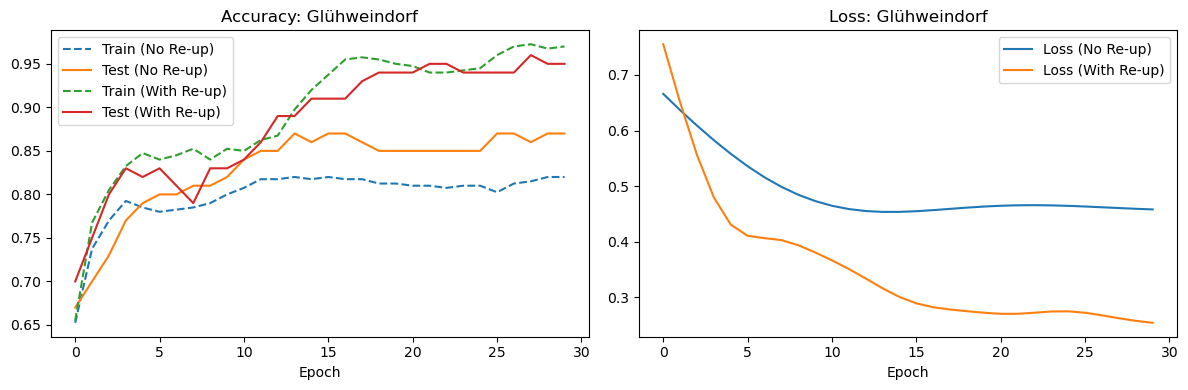

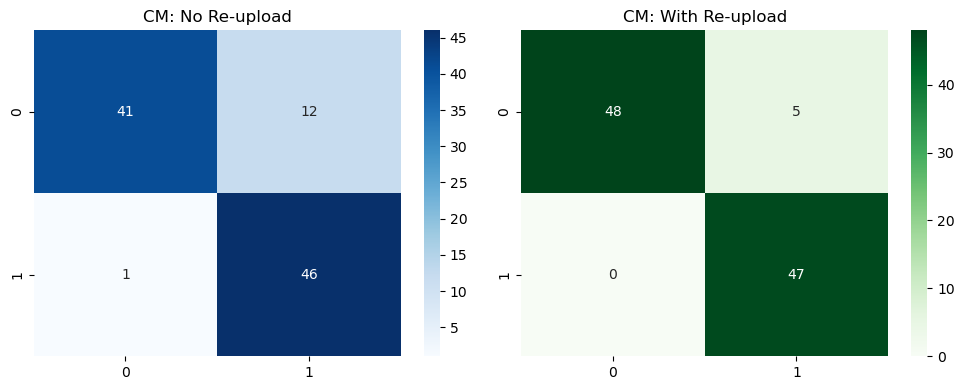

In [23]:
plot_training_results(hist_no, hist_yes, cm_no, cm_yes, village_name="Glühweindorf")

## Krampus

In [24]:
village_name = krampus 
num_qubits = 2
learning_rate = 0.1

def train_and_evaluate_2(use_reupload, epochs):
   
    count = 10 if use_reupload else 1
    
    dev = qml.device("default.qubit", wires=num_qubits)
    circuit = make_qml_circuit(dev)
    
    # Data Split
    X_v = qnp.array(X_train[village_name], requires_grad=False)
    Y_v = qnp.array(y_train[village_name], requires_grad=False)
    X_tr, X_te, Y_tr, Y_te = train_test_split(X_v, Y_v, test_size=0.1, random_state=12317240)

    weights = qnp.array(
        np.random.uniform(0, 2 * np.pi, size=(count, num_qubits, 3)),
        requires_grad=True
    )
    
    # opt = qml.NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)    
    opt = qml.AdamOptimizer(stepsize=learning_rate)
    history = {'loss': [], 'train_acc': [], 'test_acc': []}
    
    print(f"Starting Training: {village_name} | Re-upload: {use_reupload}")
    
    for epoch in range(epochs):
        params = [X_tr, Y_tr, circuit, angle_encoding_reuploading, circular_entanglement, count]
        
        weights, current_cost = opt.step_and_cost(cost, weights, params=params)

        # Predictions for metrics
        pred_tr = predict(weights, X_tr, circuit, angle_encoding_reuploading, circular_entanglement, count)
        pred_te = predict(weights, X_te, circuit, angle_encoding_reuploading, circular_entanglement, count)
        
        train_acc = qnp.mean(pred_tr == Y_tr)
        test_acc = qnp.mean(pred_te == Y_te)
        
        history['loss'].append(current_cost)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        
        print(f"Epoch {epoch+1:3d} | Cost: {current_cost:.4f} | Accuracy train: {train_acc:.3f} | Accuracy test: {test_acc:.3f}")

    # Final confusion matrix
    final_preds = predict(weights, X_te, circuit, angle_encoding_reuploading, circular_entanglement, count)
    cm = confusion_matrix(Y_te, final_preds)
    
    return history, cm

# Run both versions
hist_no_2, cm_no_2 = train_and_evaluate_2(use_reupload=False, epochs = 30)
hist_yes_2, cm_yes_2 = train_and_evaluate_2(use_reupload=True, epochs = 100)


Starting Training: krampuskogel | Re-upload: False
Epoch   1 | Cost: 1.0870 | Accuracy train: 0.491 | Accuracy test: 0.560
Epoch   2 | Cost: 1.0337 | Accuracy train: 0.489 | Accuracy test: 0.580
Epoch   3 | Cost: 0.9886 | Accuracy train: 0.491 | Accuracy test: 0.580
Epoch   4 | Cost: 0.9502 | Accuracy train: 0.480 | Accuracy test: 0.580
Epoch   5 | Cost: 0.9173 | Accuracy train: 0.484 | Accuracy test: 0.580
Epoch   6 | Cost: 0.8886 | Accuracy train: 0.484 | Accuracy test: 0.600
Epoch   7 | Cost: 0.8634 | Accuracy train: 0.484 | Accuracy test: 0.580
Epoch   8 | Cost: 0.8411 | Accuracy train: 0.484 | Accuracy test: 0.560
Epoch   9 | Cost: 0.8212 | Accuracy train: 0.487 | Accuracy test: 0.540
Epoch  10 | Cost: 0.8034 | Accuracy train: 0.491 | Accuracy test: 0.540
Epoch  11 | Cost: 0.7873 | Accuracy train: 0.489 | Accuracy test: 0.520
Epoch  12 | Cost: 0.7729 | Accuracy train: 0.491 | Accuracy test: 0.520
Epoch  13 | Cost: 0.7603 | Accuracy train: 0.496 | Accuracy test: 0.520
Epoch  14 | C

Epoch  84 | Cost: 0.2643 | Accuracy train: 0.951 | Accuracy test: 0.920
Epoch  85 | Cost: 0.2641 | Accuracy train: 0.949 | Accuracy test: 0.920
Epoch  86 | Cost: 0.2639 | Accuracy train: 0.947 | Accuracy test: 0.900
Epoch  87 | Cost: 0.2638 | Accuracy train: 0.947 | Accuracy test: 0.880
Epoch  88 | Cost: 0.2636 | Accuracy train: 0.949 | Accuracy test: 0.880
Epoch  89 | Cost: 0.2635 | Accuracy train: 0.949 | Accuracy test: 0.880
Epoch  90 | Cost: 0.2634 | Accuracy train: 0.947 | Accuracy test: 0.880
Epoch  91 | Cost: 0.2632 | Accuracy train: 0.947 | Accuracy test: 0.900
Epoch  92 | Cost: 0.2630 | Accuracy train: 0.944 | Accuracy test: 0.900
Epoch  93 | Cost: 0.2629 | Accuracy train: 0.944 | Accuracy test: 0.900
Epoch  94 | Cost: 0.2627 | Accuracy train: 0.947 | Accuracy test: 0.900
Epoch  95 | Cost: 0.2625 | Accuracy train: 0.947 | Accuracy test: 0.900
Epoch  96 | Cost: 0.2624 | Accuracy train: 0.947 | Accuracy test: 0.900
Epoch  97 | Cost: 0.2622 | Accuracy train: 0.947 | Accuracy test

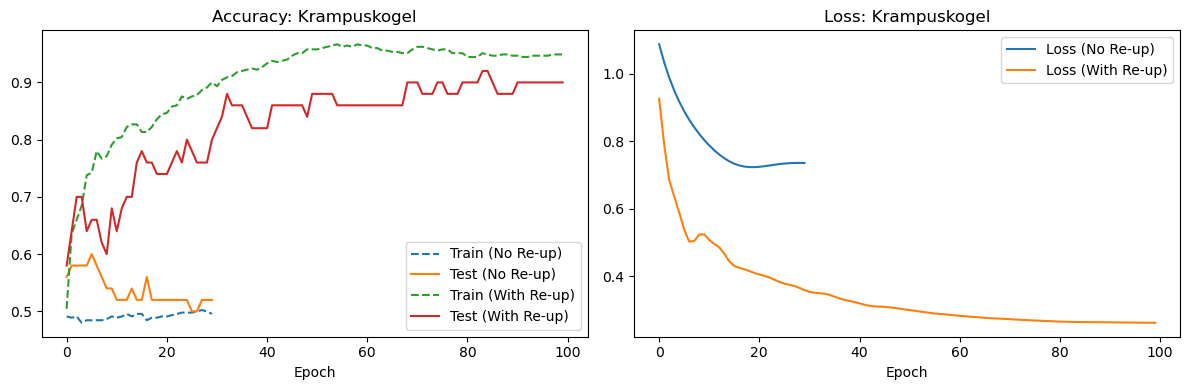

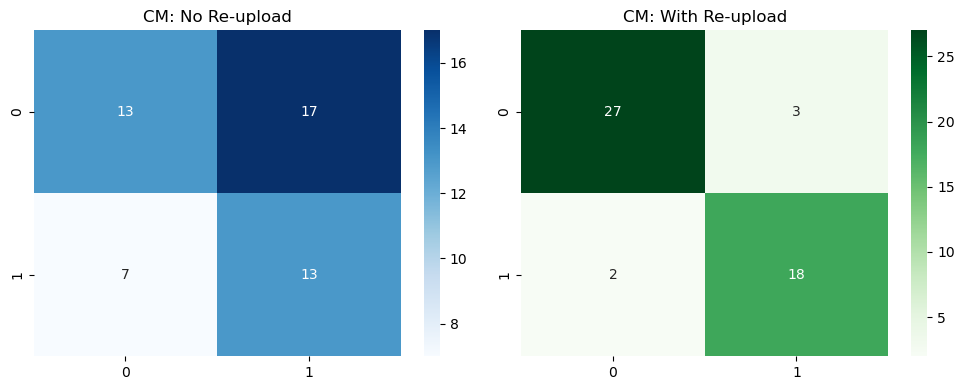

In [25]:
plot_training_results(hist_no_2, hist_yes_2, cm_no_2, cm_yes_2, village_name="Krampuskogel")

## Lebkuchen

In [27]:
village_name = lebkuchen 
num_qubits = 2
learning_rate = 0.1

def train_and_evaluate_2(use_reupload, epochs):
   
    count = 5 if use_reupload else 1
    
    dev = qml.device("default.qubit", wires=num_qubits)
    circuit = make_qml_circuit(dev)
    
    # Data Split
    X_v = qnp.array(X_train[village_name], requires_grad=False)
    Y_v = qnp.array(y_train[village_name], requires_grad=False)
    X_tr, X_te, Y_tr, Y_te = train_test_split(X_v, Y_v, test_size=0.1, random_state=12317240)

    weights = qnp.array(
        np.random.uniform(0, 2 * np.pi, size=(count, num_qubits, 3)),
        requires_grad=True
    )
    
    opt = qml.NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)    
    history = {'loss': [], 'train_acc': [], 'test_acc': []}
    
    print(f"Starting Training: {village_name} | Re-upload: {use_reupload}")
    
    for epoch in range(epochs):
        params = [X_tr, Y_tr, circuit, angle_encoding_reuploading, circular_entanglement, count]
        
        weights, current_cost = opt.step_and_cost(cost, weights, params=params)

        # Predictions for metrics
        pred_tr = predict(weights, X_tr, circuit, angle_encoding_reuploading, circular_entanglement, count)
        pred_te = predict(weights, X_te, circuit, angle_encoding_reuploading, circular_entanglement, count)
        
        train_acc = qnp.mean(pred_tr == Y_tr)
        test_acc = qnp.mean(pred_te == Y_te)
        
        history['loss'].append(current_cost)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        
        print(f"Epoch {epoch+1:3d} | Cost: {current_cost:.4f} | Accuracy train: {train_acc:.3f} | Accuracy test: {test_acc:.3f}")

    # Final confusion matrix
    final_preds = predict(weights, X_te, circuit, angle_encoding_reuploading, circular_entanglement, count)
    cm = confusion_matrix(Y_te, final_preds)
    
    return history, cm

# Run both versions
hist_no_3, cm_no_3 = train_and_evaluate_2(use_reupload=False, epochs = 30)
hist_yes_3, cm_yes_3 = train_and_evaluate_2(use_reupload=True, epochs = 100)


Starting Training: lebkuchenstadt | Re-upload: False
Epoch   1 | Cost: 0.8984 | Accuracy train: 0.496 | Accuracy test: 0.460
Epoch   2 | Cost: 0.8972 | Accuracy train: 0.500 | Accuracy test: 0.460
Epoch   3 | Cost: 0.8954 | Accuracy train: 0.500 | Accuracy test: 0.460
Epoch   4 | Cost: 0.8927 | Accuracy train: 0.509 | Accuracy test: 0.460
Epoch   5 | Cost: 0.8891 | Accuracy train: 0.502 | Accuracy test: 0.500
Epoch   6 | Cost: 0.8842 | Accuracy train: 0.502 | Accuracy test: 0.500
Epoch   7 | Cost: 0.8776 | Accuracy train: 0.511 | Accuracy test: 0.480
Epoch   8 | Cost: 0.8690 | Accuracy train: 0.507 | Accuracy test: 0.460
Epoch   9 | Cost: 0.8583 | Accuracy train: 0.513 | Accuracy test: 0.460
Epoch  10 | Cost: 0.8454 | Accuracy train: 0.511 | Accuracy test: 0.480
Epoch  11 | Cost: 0.8306 | Accuracy train: 0.518 | Accuracy test: 0.480
Epoch  12 | Cost: 0.8145 | Accuracy train: 0.513 | Accuracy test: 0.480
Epoch  13 | Cost: 0.7977 | Accuracy train: 0.504 | Accuracy test: 0.460
Epoch  14 |

Epoch  84 | Cost: 0.3128 | Accuracy train: 0.924 | Accuracy test: 0.920
Epoch  85 | Cost: 0.3114 | Accuracy train: 0.924 | Accuracy test: 0.900
Epoch  86 | Cost: 0.3099 | Accuracy train: 0.924 | Accuracy test: 0.900
Epoch  87 | Cost: 0.3085 | Accuracy train: 0.927 | Accuracy test: 0.900
Epoch  88 | Cost: 0.3072 | Accuracy train: 0.927 | Accuracy test: 0.900
Epoch  89 | Cost: 0.3059 | Accuracy train: 0.927 | Accuracy test: 0.900
Epoch  90 | Cost: 0.3047 | Accuracy train: 0.924 | Accuracy test: 0.900
Epoch  91 | Cost: 0.3035 | Accuracy train: 0.922 | Accuracy test: 0.900
Epoch  92 | Cost: 0.3024 | Accuracy train: 0.922 | Accuracy test: 0.900
Epoch  93 | Cost: 0.3014 | Accuracy train: 0.922 | Accuracy test: 0.900
Epoch  94 | Cost: 0.3004 | Accuracy train: 0.924 | Accuracy test: 0.900
Epoch  95 | Cost: 0.2996 | Accuracy train: 0.924 | Accuracy test: 0.900
Epoch  96 | Cost: 0.2988 | Accuracy train: 0.924 | Accuracy test: 0.900
Epoch  97 | Cost: 0.2981 | Accuracy train: 0.922 | Accuracy test

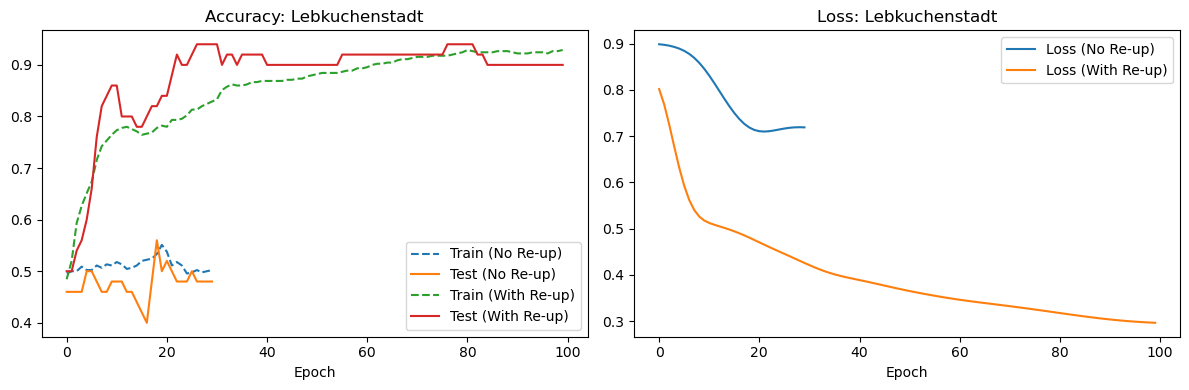

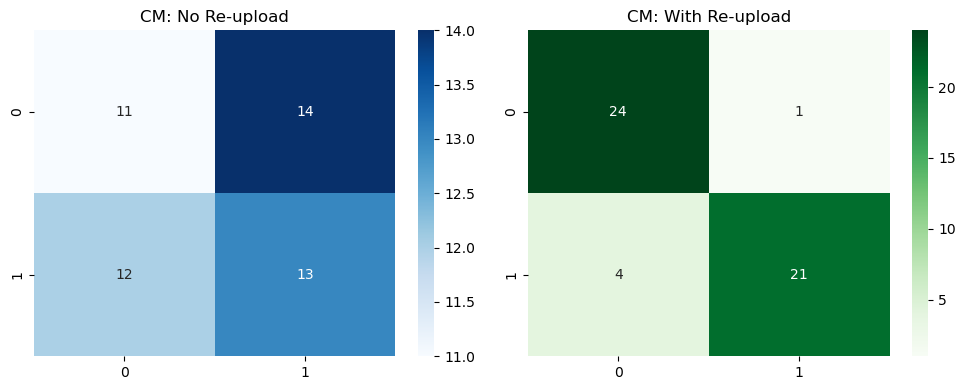

In [28]:
plot_training_results(hist_no_3, hist_yes_3, cm_no_3, cm_yes_3, village_name="Lebkuchenstadt")